# Introduction 
`V1.0.2`
### Who am I
Just a fellow Kaggle learner. I was creating this Notebook as practice and thought it could be useful to some others 
### Who is this for
This Notebook is for people that learn from examples. Forget the boring lectures and follow along for a fun and instructive time :)
### What can I learn here
You learn all the basics needed to create a transfer learning model. You will learn things ranging from Transfer Learning, Data Augmentation, Data Preprocessing and ect. I go over a multitude of steps with explanations. Hopefully this notebook can inspire you and help you to work on your own notebook.

### Things to remember
+ Please Upvote/Like the Notebook so other people can learn from it
+ Feel free to give any recommendations/changes. 
+ I will be continuously updating the notebook. Look forward to many more upcoming changes in the future.

### You can also refer to these notebooks that have helped me as well:
+ https://www.kaggle.com/code/jirkaborovec/bloodclots-classif-baseline-flash-effnet-aug?scriptVersionId=101586230
+ https://www.kaggle.com/code/jirkaborovec/bloodclots-eda-load-wsi-prune-background
+ https://www.kaggle.com/code/queyrusi/mayo-clots-vgg11-gpu-train-submission

# Installs
Here we are installing specific versions of Tensorflow and Pillow libraries. This is to allow us to use a more recent version of EfficientNet Model and also to make use of the updated methods of Pillow. Please uncomment these cells and install the proper versions. After the install is completed, please restart & clear cell outputs.

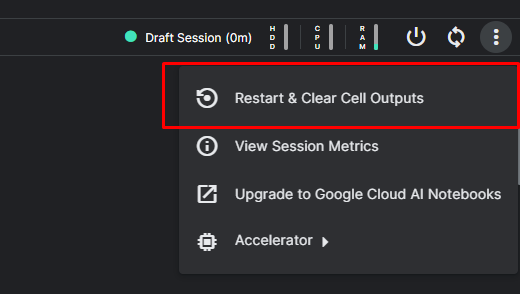

In [ ]:
# !pip install tensorflow==2.9.1

In [ ]:
# !pip install Pillow==9.2.0

# Imports
In this section, we are going to import all the relevant libraries.

In [ ]:
# Python Imports
import os
import gc
import csv
import string
import shutil
from glob import glob
from pathlib import Path
from tqdm.auto import tqdm

# Computing imports
import pandas as pd
import numpy as np
import PIL

# ML imports
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop, Adam 
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Plotting imports
import matplotlib.pyplot as plt

# I like to disable my Notebook Warnings.
import warnings
from warnings import simplefilter
warnings.filterwarnings("ignore")

# Allows us to see more information regarding the DataFrame
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None) 

Let's check if the notebook has been updated with the current versions of the libraries.

In [ ]:
tf.__version__, PIL.__version__

# Configuration
In this section, we set all the constants and variables that we will re-use throughout the notebook. It makes our lives easier to have all the configurable variables at one place. Note that the image size that we will feed to the model is (300, 300). This is not chosen randomnly. You can find the recommended image size for the model you want to use for transfer learning. In our case, Efficientnetv2B3 recommends a 300x300 input image.

In [ ]:
IMG_SIZE = (300, 300) # https://tfhub.dev/google/collections/efficientnet_v2/1#:~:text=classification%0Afeature_vector-,Efficientnetv2%20B3,-300
IMG_CHANNELS = 3      # RGB Channels
BATCH_SIZE = 64       # You can play with this hyperparameter. I kept it at 64 batch size so that the notebook runs quickly
EPOCHS = 5            # You can play with this hyperparameter. I kept it at 5 Epochs so that the notebook runs quickly
LR = 0.0001           # We want learnnig rate to be small since we are only fine tuning the prediction head of the Neural Network

# Helper Functions
This functions will help us to preprocess our images. They have been taken from this amazing notebook: https://www.kaggle.com/code/jirkaborovec/bloodclots-classif-baseline-flash-effnet-aug?scriptVersionId=101586230

In [ ]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = 25_000_000_000  # you have to set this value to allow displaying high-resolution images

def prune_image_rows_cols(im, mask, thr=0.990):
    """
    This function removes empty rows and columns. These rows and columns
    do not provide valuable information to the model and increases the 
    input tensor considerably.
    """
    # delete empty columns
    for l in reversed(range(im.shape[1])):
        if (np.sum(mask[:, l]) / float(mask.shape[0])) > thr:
            im = np.delete(im, l, 1)
    # delete empty rows
    for l in reversed(range(im.shape[0])):
        if (np.sum(mask[l, :]) / float(mask.shape[1])) > thr:
            im = np.delete(im, l, 0)
    return im


def mask_median(im, val=255):
    """
    Helps to remove background colors
    """
    masks = [None] * 3
    for c in range(3):
        masks[c] = im[..., c] >= np.median(im[:, :, c]) - 5
    mask = np.logical_and(*masks)
    im[mask, :] = val
    return im, mask


def image_load_scale_norm(img_path, prune_thr=0.990, bg_val=255):
    """
    Function that normalized our images
    """
    img = Image.open(img_path)
    if (img.width * img.height) > 1_500_000_000:  # todo: for train images it was fine 4_000_000_000
        print(img.width, img.height)
        return None
    scale = min(img.height / 2e3, img.width / 2e3)
    tmp_size = int(img.width / scale), int(img.height / scale)
    img.thumbnail(tmp_size, resample=Image.Resampling.BILINEAR, reducing_gap=scale)
    im, mask = mask_median(np.array(img), val=bg_val)
    im = prune_image_rows_cols(im, mask, thr=prune_thr)
    img = Image.fromarray(im)
    scale = min(img.height / 1e3, img.width / 1e3)
    if scale > 1:
        img = img.resize((int(img.width / scale), int(img.height / scale)), Image.LANCZOS)
    return img

# Importing Data
1. Since data is in form of csv file we have to use pandas read_csv to load the data
2. Let's first define the paths that we will need to import our data.
3. After loading it is important to check the complete information of data. It is important to get a general feel of the data that we are going to be using.

In [ ]:
MAYO_CLINIC_FOLDER = Path("../input/mayo-clinic-strip-ai/")
STROKE_BLOOD_FOLDER = Path("../input/stroke-blood-clot-origin-1k-scale-bg-crop")

ORIGINAL_TRAIN_FOLDER = MAYO_CLINIC_FOLDER / "train"
TEST_FOLDER = MAYO_CLINIC_FOLDER / "test"
OTHER_FOLDER = MAYO_CLINIC_FOLDER / "other"

NORMALIZED_TRAIN_FOLDER = STROKE_BLOOD_FOLDER / "train_images" # taken from https://www.kaggle.com/code/jirkaborovec/bloodclots-classif-eda-load-crop-images/data
NORMALIZED_TEST_FOLDER =  Path("./norm-test-images/normalized_test_images") 

TRAIN_DATA_PATH = MAYO_CLINIC_FOLDER / "train.csv"
TEST_DATA_PATH = MAYO_CLINIC_FOLDER / "test.csv"
OTHER_DATA_PATH = MAYO_CLINIC_FOLDER / "other.csv"
SAMPLE_SUBMISSION_PATH = MAYO_CLINIC_FOLDER / "sample_submission.csv"

train_df = pd.read_csv(TRAIN_DATA_PATH)
test_df = pd.read_csv(TEST_DATA_PATH)
sample_submission_df = pd.read_csv(SAMPLE_SUBMISSION_PATH)

train_df.head()

After working on this competition, I realized that these two images cause issues for the training of the model. I chose to remove them from the training data.

In [ ]:
print(f"Before drop: {train_df.shape}")
train_df = train_df[train_df["image_id"] != "b894f4_0"] 
train_df = train_df[train_df["image_id"] != "6baf51_0"]
print(f"After drop: {train_df.shape}")

In the next cell, we create a new folder that will hold our test images in PNG format. These images will be used to create the submission file for the competition.

In [ ]:
ls_imgs_tif = glob(os.path.join(TEST_FOLDER, "*.tif"))
names = [os.path.splitext(os.path.basename(p))[0] for p in ls_imgs_tif]
patient_ids = set([n.split("_")[0] for n in names])
print(patient_ids)

if NORMALIZED_TEST_FOLDER.exists():
    shutil.rmtree(NORMALIZED_TEST_FOLDER)
    
NORMALIZED_TEST_FOLDER.mkdir(parents=True, exist_ok=True)

for img_path in tqdm(ls_imgs_tif):
    name, _ = os.path.splitext(os.path.basename(img_path))
    img = image_load_scale_norm(img_path)
    if not img:
        print(f"missing: {name}")
        continue
    img.save(NORMALIZED_TEST_FOLDER / f"{name}.png")
    del img
    gc.collect()

# EDA/Visualizations
The goal is to try and gain insights from the data prior to modeling.

## Explorating the Dataframe
It is useful to use .info() method to quickly have a glance on the general information about the DataFrame. It displays info such as the type of the columnd and also the # of non-null count.

In [ ]:
train_df.info()

let's also see how many images we are working with for training and testing.

In [ ]:
train_images = glob(str(NORMALIZED_TRAIN_FOLDER / "*"))
test_images = glob(str(NORMALIZED_TEST_FOLDER / "*"))

print(f"Number of images in a training set: {len(train_images)}")
print(f"Number of images in a training set: {len(test_images)}")

We can also visualize one of the training pictures and see how it looks.

In [ ]:
picture_path = next(NORMALIZED_TRAIN_FOLDER.iterdir())
plt.style.use("seaborn-whitegrid")

img = Image.open(picture_path)   
img.thumbnail((300,300), Image.Resampling.LANCZOS)
plt.imshow(img)
plt.show()

# Feature Engineering / Prepare the data

Here we are creating a new column in the dataframe that will hold the path to the respective image.

In [ ]:
train_df["path"] = train_df["image_id"].apply(lambda x: NORMALIZED_TRAIN_FOLDER / f"{x}.png")
train_df["path"] = train_df["path"].astype(str)

We select only the two columns that we need. In this case, it would be the path column and label column.

In [ ]:
selected_train_df = train_df[["path", "label"]]
selected_train_df['label'] = selected_train_df['label'].astype('category')
selected_train_df.head(10)

# Models
In this section, we will be using transfer learning to build our prediction model. We will be using the EfficientNetV2B3 as the backbone feature extractor. You can find more information here: https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet_v2/EfficientNetV2B3

In [ ]:
# Image size of (300, 300, 3)
IMG_SHAPE = IMG_SIZE + (IMG_CHANNELS,)
# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
pre_trained_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# Set trainable to false for the pretrained model. We only want to train the dense layers we will be addind for prediction
pre_trained_model.trainable = False


## Preparing for Training
Here we will build our data generators that will feed our model with data for training and testing. Note that we are using data augmentation for the train and validation generators. We do not augment the data for testing.
We are also not using any rescaling since the EfficientNetV2B3 model already does rescaling as part of the model.

In [ ]:
from sklearn.model_selection import train_test_split

def train_val_generators(train_df, test_df):
    
    # No rescaling needed since it is included in the efficientnet model
    train_datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=0.3
    )
    
    # Train and validation will be used during training. Validation score is what we look at to tune the hyperparameters and to assess if our model is overfitting or not
    train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, x_col='path', y_col='label',class_mode='binary', subset='training', color_mode='rgb', target_size=IMG_SIZE, batch_size=BATCH_SIZE)
    validation_generator = train_datagen.flow_from_dataframe(dataframe=train_df, x_col='path', y_col='label',class_mode='binary', subset='validation', color_mode='rgb', target_size=IMG_SIZE, batch_size=BATCH_SIZE)
    
    # The test generator will be used to create the final submission
    test_datagen = ImageDataGenerator()
    test_generator = test_datagen.flow_from_directory("./norm-test-images",
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode="binary",
    shuffle=False,
)


    return train_generator, validation_generator, test_generator

In [ ]:
train_generator, validation_generator, test_generator = train_val_generators(selected_train_df, test_df)

We can analyze the shape of one image batch and also the shape of output tensor after it goes through the backbone model.

In [ ]:
image_batch, label_batch = next(train_generator)
image_batch.shape

In [ ]:
feature_batch = pre_trained_model(image_batch)
print(feature_batch.shape)

We can also visualize the training data from the created generator.

In [ ]:
fit, ax= plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax=ax.flatten()
j=0
for _ in range(6):
    img, label = train_generator.next()
    ax[j].imshow(img[0],)
    ax[j].set_title(label[0])
    j=j+1

It is important to understand how the classes our mapped in the generator. In our case, CA is 0 and LAA is 1.

In [ ]:
train_generator.class_indices

In [ ]:
pre_trained_model.summary()

Before creating our full model, let's understand what type of model is our pre trained model. We are trying to understand if it built using the TensorFlow sequential or functional API.

In [ ]:
# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(pre_trained_model)}")

We notice that it is built using the functional API. We can now proceed on adding our last few dense layers to complete our model.

In [ ]:
def create_final_model(pre_trained_model):
    
    # Flatten the output layer to 1 dimension
    x = layers.Flatten()(pre_trained_model.output)

    ### START CODE HERE

    # Add a fully connected layer with 512 hidden units and ReLU activation
    x = layers.Dense(512, activation='relu')(x)
    # Add a dropout rate of 0.2 
    x = layers.Dropout(0.2)(x)  
    # Add a fully connected layer with 128 hidden units and ReLU activation
    x = layers.Dense(128, activation='relu')(x)
    # Add a dropout rate of 0.2
    x = layers.Dropout(0.2)(x)     
    # Add a fully connected layer with 64 hidden units and ReLU activation
    x = layers.Dense(64, activation='relu')(x)
    # Add a final sigmoid layer for classification
    x = layers.Dense(1, activation='sigmoid')(x)       

    # Create the complete model by using the Model class
    model = Model(inputs=pre_trained_model.input, outputs=x)

    # Compile the model
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LR), 
                loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics = ['accuracy'])

    return model

In [ ]:
# Save your model in a variable
model = create_final_model(pre_trained_model)

In [ ]:
# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

<div class="alert alert-block alert-info">
<b>Remark:</b> You can notice that even though we only added 4 dense layers, there are many trainable parameters that have been added that are not included in the backbone model (EfficientNetV2B3). This is due to the fact that we are flattening that last output of the backbone and propagating it through all those 4 dense layers. The amount of trainable parameters, in this case, increases very rapidly.
</div>

## Training
We've prepared the food (data), time to... FEED THE MACHINE. We use three different callbacks that give additional functionality during training. Pleaes research them to get a deeper understanding on what each of the callback is doing: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=4)

filepath = "./model.h5"
checkpoint = ModelCheckpoint(filepath, monitor="val_acc", verbose=1, save_best_only=True, mode="max")

reduce_lr = ReduceLROnPlateau(monitor="val_acc", factor=0.5, patience=2, verbose=1, mode="max", min_lr=0.00001)

callbacks_list = [early_stop, checkpoint, reduce_lr]

history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = EPOCHS,
                    verbose = 2,
                    callbacks=callbacks_list)

## Plot training results
It is important to plot our training results and inspect if our model is performing well. It is important to look at the validation accuracy and loss to understand if our model is overfitting our training data. In our case, we are only training for 1 Epoch, therefore we are not expecting great results.

In [ ]:
plt.style.use("seaborn-whitegrid")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Crossentropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Save model
After iterating and playing with your hyperparameters to reach better scores, you can save and load your model with the following code blocks. It would be annoying to always need to train your model to continue working on your notebook... better to load it.

### Saving only the weights

In [ ]:
# # Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

In [ ]:
# # Create a new model instance
# model = create_final_model(pre_trained_model)

# # Restore the weights
# model.load_weights('../input/trained-models/checkpoints/my_checkpoint')

### Saving the whole model

In [ ]:
# Save the entire model as a SavedModel.
# https://www.tensorflow.org/tutorials/keras/save_and_load#savedmodel_format

# !mkdir -p saved_model
# model.save('saved_model/my_model')
# !zip -r 'saved_model.zip' './saved_model'

## Predicting & Submitting
Here I am loading a model I trained and tuned the hyperarameters. I will be using this model for predicting the test images.

In [ ]:
model = tf.keras.models.load_model('../input/mayo-clinic-saved-model/my_model')

We will now use the test generator to predict our submission results.

In [ ]:
ls_imgs_png = glob(os.path.join("./norm-test-images/normalized_test_images", "*.png"))
amount_of_test_images = len(ls_imgs_png)
amount_of_test_images

In [ ]:
laa_predictions = model.predict(test_generator, steps=amount_of_test_images, verbose=1)

<div class="alert alert-block alert-danger">  
Note that since LAA is class 1, the model is predicting the probability for LAA. 
</div>

In [ ]:
ca_preds = 1 - laa_predictions
preds = np.concatenate((laa_predictions, ca_preds), axis=1)

In [ ]:
# Put the predictions into a dataframe
df_preds = pd.DataFrame(preds, columns=["LAA", "CE"])
df_preds.head()

In [ ]:
names = [os.path.splitext(os.path.basename(p))[0] for p in ls_imgs_png]
df_preds["patient_id"] = [n.split("_")[0] for n in names]
df_preds.head()

Here we will be adding back the images that were discarded because they were too big. We will be filling the CE and LAA prediction probabilities with hardcoded mean values. In the future, it would be interesting to use the mean of CE and LAA probabilities of all images as the filling value instead of hardcoded values.

In [ ]:
# fill missing if skipped for too large image size
missed = [{"CE": 0.6, "LAA": 0.4, "patient_id": pid} for pid in patient_ids if pid not in df_preds["patient_id"].values]
df_preds = df_preds.append(pd.DataFrame(missed), ignore_index=True)
df_preds.head()

In [ ]:
# in case there are many samples for one patient --> use mean value
df_preds = df_preds.groupby("patient_id").mean()
df_preds[["CE", "LAA"]].round(6)
df_preds.reset_index(inplace=True)

In [ ]:
df_preds.to_csv("submission.csv", index=False)

# Final Remarks
Thank you for going through this notebook. Please feel free to show support and comment on the notebooks with advice or improvements. If you found it useful, please let me know as well :)